In [20]:
from writers import CSV
from analyzers import DatasetEntropyAnalyzer
from datasets import TomographyArrayDownsampled
from utils.data_factory import DataFactory
from image_processing_pipelines import ThresholdClusterPipeline
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sympy as sp

In [21]:
# Sets up a tomography to pull slices from
print("Compiling Dataset...")
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2012-09-23-53/20120923_Hylemonella_50001_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Hylemonella gracilis/yc2013-01-03-21/Bdel_Hyle_0020009_full.rec"
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/3/Bdellovibrio_ConventionalTilt3_full.rec"
tomo_path = ["/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/good/FromGeorges_FastTilt/17/BD_1deg_2um_Aug25_15.30.48_af_combined_SIRT_1k.ctf.rec", "/home/matiasgp/groups/grp_tomo_db1_d3/nobackup/archive/TomoDB1_d3/Bdellovibrio_Krios/ConventionalTilt/3/Bdellovibrio_ConventionalTilt3_full.rec"]
#tomo_path = "/home/matiasgp/groups/grp_tomo_db1_d1/nobackup/archive/TomoDB1_d1/FlagellarMotor_P1/Caulobacter crescentus"
data = TomographyArrayDownsampled(tomo_path, factor=10)

Compiling Dataset...


Initialized with 2 files.


In [22]:
# Sets up an analysis pipeline
print("Setting up Analysis Pipeline...")
analyzer = DatasetEntropyAnalyzer()

Setting up Analysis Pipeline...


In [23]:
# Sets up a writer
print("Setting up Writer...")
writer = CSV("dataset_means_analysis.csv")

Setting up Writer...


In [24]:
print("Configuring Processor...")
batch_size = 1
data_factory = DataFactory(
    analyzer,
    writer,
    batch_size
)

Configuring Processor...


In [25]:
print("Processing Data...")
results = data_factory.process(data, "Processing Slice")

Processing Data...


Processing Slice:  50%|█████     | 1/2 [00:02<00:02,  2.05s/it]

Data saved to dataset_means_analysis.csv


Now we want to plot the entropy analysis in a graph, just like the means analyzer.

In [26]:
degree = 7 # Degree of the polynomial to fit
entropy0 = results[tomo_path[0]]["entropy_0"]
entropy1 = results[tomo_path[0]]["entropy_1"]
entropy2 = results[tomo_path[0]]["entropy_2"]
means0 = results[tomo_path[0]]["means_0"]
means1 = results[tomo_path[0]]["means_1"]
means2 = results[tomo_path[0]]["means_2"]
tomo = results[tomo_path[0]]["data"]
print(tomo.shape)


(30, 92, 95)


In [27]:
def fit_and_normalize_index(numbers, degree=2):
    """
    Fit a polynomial to the data using normalized indices as x-coordinates
    and normalize the y-values as well.

    Parameters:
    - numbers: list of y-values to fit
    - degree: degree of the polynomial to fit

    Returns:
    - normalized_polynomial: polynomial function with normalized x (as a sympy expression)
    - normalized_x: normalized x-values
    - normalized_y: normalized y-values
    """
    # Generate the index values (independent variable)
    x = np.arange(len(numbers))
    y = np.array(numbers)

    # Normalize the index values to the range [0, 1]
    normalized_x = (x - x.min()) / (x.max() - x.min())

    # Normalize the y-values to the range [0, 1]
    normalized_y = (y - y.min()) / (y.max() - y.min())

    # Fit a polynomial of the specified degree using numpy
    coefficients = np.polyfit(normalized_x, normalized_y, degree)
    
    # Convert coefficients to sympy expression
    x_sym = sp.symbols('x')
    normalized_polynomial = sum(c * x_sym**i for i, c in enumerate(reversed(coefficients)))

    return normalized_polynomial, normalized_x, normalized_y

In [28]:
def find_local_extrema_and_inflection(normalized_polynomial):
    """
    Find the local minima and inflection points of the normalized polynomial.

    Parameters:
    - normalized_polynomial: normalized polynomial function (as a sympy expression)

    Returns:
    - local_minima: list of tuples (x, y) for local minima
    - inflection_points: list of tuples (x, y) for inflection points
    """
    x_sym = sp.symbols('x')

    # Compute the first and second derivatives of the polynomial
    derivative = sp.diff(normalized_polynomial, x_sym)
    second_derivative = sp.diff(derivative, x_sym)
    third_derivative = sp.diff(second_derivative, x_sym)
    
    # Solve for the critical points (where the first derivative is zero)
    critical_points = sp.solveset(derivative, x_sym, domain=sp.Interval(0, 1))
    inflection_points = sp.solveset(second_derivative, x_sym, domain=sp.Interval(0, 1))
    
    # Convert critical points to numerical values
    critical_points = [float(point.evalf()) for point in critical_points]
    inflection_points = [float(point.evalf()) for point in inflection_points]
    
    # Find local minima among the critical points
    local_minima = []
    for point in critical_points:
        if second_derivative.subs(x_sym, point) > 0:  # Check if it's a local minimum
            y_min = float(normalized_polynomial.subs(x_sym, point))
            local_minima.append((point, y_min))
    
    # Find inflection points
    inflection_points_final = []
    for point in inflection_points:
        if third_derivative.subs(x_sym, point) != 0:  # Ensure it's an actual inflection point
            y_inflection = float(normalized_polynomial.subs(x_sym, point))
            inflection_points_final.append((point, y_inflection))
    
    return local_minima, inflection_points_final

def find_nearest_extreme(normalized_polynomial):
    """
    Find the nearest local minimum to x = 0.5. If no minimum is found, return the nearest inflection point.

    Parameters:
    - normalized_polynomial: normalized polynomial function (as a sympy expression)

    Returns:
    - x_extreme: x-coordinate of the nearest local minimum or inflection point to x = 0.5
    - y_extreme: y-coordinate of the nearest local minimum or inflection point
    """
    local_minima, inflection_points = find_local_extrema_and_inflection(normalized_polynomial)
    
    if not local_minima:
        if inflection_points:
            # If no local minima, find the nearest inflection point
            center = 0.5
            nearest_inflection = min(inflection_points, key=lambda point: abs(point[0] - center))
            return nearest_inflection
        else:
            raise ValueError("No local minima or inflection points found in the interval [0, 1]")
    
    # Find the nearest minimum
    center = 0.5
    nearest_minima = min(local_minima, key=lambda min_point: abs(min_point[0] - center))
    return nearest_minima

def plot_normalized_index(numbers1, normalized_polynomial1, normalized_x1, 
                           numbers2=None, normalized_polynomial2=None, normalized_x2=None, 
                           title=''):
    """
    Plot the normalized polynomials with original data points and optionally a second set of data points and polynomial.

    Parameters:
    - numbers1: list of original y-values for the first set
    - normalized_polynomial1: polynomial function with normalized x for the first set (as a sympy expression)
    - normalized_x1: normalized x-values for the first set
    - numbers2: (optional) list of original y-values for the second set
    - normalized_polynomial2: (optional) polynomial function with normalized x for the second set (as a sympy expression)
    - normalized_x2: (optional) normalized x-values for the second set
    - title: Title of the plot
    """
    y1 = np.array(numbers1)

    # Generate x values for plotting the first normalized polynomial
    x_fit1 = np.linspace(normalized_x1.min(), normalized_x1.max(), 100)
    normalized_polynomial_func1 = sp.lambdify(sp.symbols('x'), normalized_polynomial1, 'numpy')
    y_fit1 = normalized_polynomial_func1(x_fit1)

    # Plot the first set of data points and polynomial
    plt.scatter(normalized_x1, y1, color='blue', label='Original data 1')
    plt.plot(x_fit1, y_fit1, color='red', label='Entropy')

    # Plot the second set of data points and polynomial if provided
    if numbers2 is not None and normalized_polynomial2 is not None and normalized_x2 is not None:
        y2 = np.array(numbers2)
        plt.scatter(normalized_x2, y2, color='green', label='Original data 2')

        x_fit2 = np.linspace(normalized_x2.min(), normalized_x2.max(), 100)
        normalized_polynomial_func2 = sp.lambdify(sp.symbols('x'), normalized_polynomial2, 'numpy')
        y_fit2 = normalized_polynomial_func2(x_fit2)
        plt.plot(x_fit2, y_fit2, color='orange', label='Means')

    # # Find the nearest local extreme for the first polynomial
    # try:
    #     x_extreme, y_extreme = find_nearest_extreme(normalized_polynomial1)
    #     extreme_label = 'Nearest Local Minimum/Inflection'
    # except ValueError:
    #     x_extreme, y_extreme = None, None
    #     extreme_label = None

    # # Plot the nearest local extreme if found
    # if x_extreme is not None:
    #     plt.scatter(x_extreme, y_extreme, color='purple', zorder=5, label=extreme_label)

    # # Find local minima and inflection points for the first polynomial
    # local_minima, inflection_points = find_local_extrema_and_inflection(normalized_polynomial1)

    # # Plot local minima
    # for x_min, y_min in local_minima:
    #     plt.scatter(x_min, y_min, color='pink', zorder=5, label='Local Minimum')

    # # Plot inflection points
    # for x_infl, y_infl in inflection_points:
    #     plt.scatter(x_infl, y_infl, color='yellow', zorder=5, label='Inflection Point')

    # Add labels and legend
    plt.xlabel('Slice')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

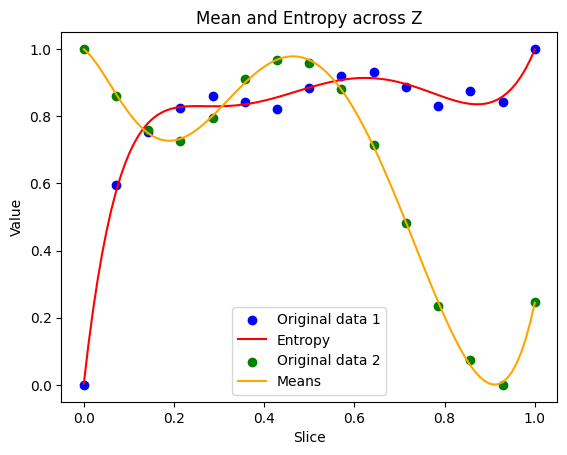

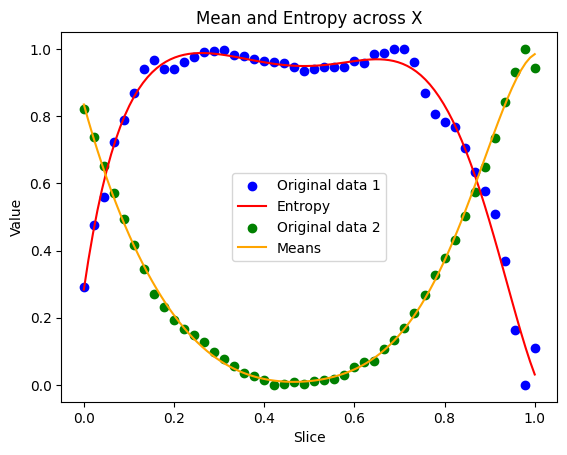

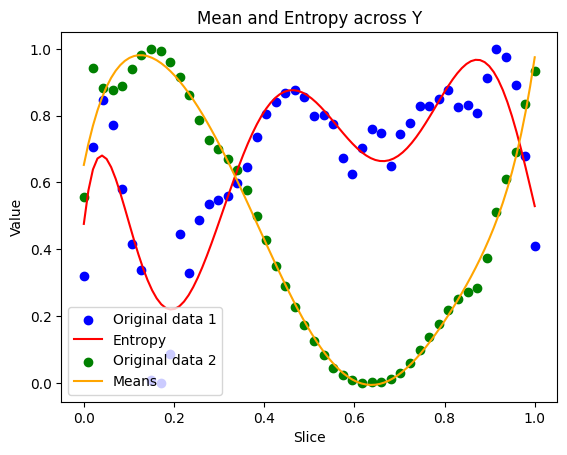

In [29]:
# Fit the ENTROPY0 polynomial and get the normalized polynomial and normalized x values
entropy_polynomial0, x_e0, y_e0 = fit_and_normalize_index(entropy0, degree)
# Fit the MEANS0 polynomial
means_polynomial0, x_m0, y_m0 = fit_and_normalize_index(means0, degree)
# Plot the MEANS0 polynomial
plot_normalized_index(y_e0, entropy_polynomial0, x_e0, y_m0, means_polynomial0, x_m0, "Mean and Entropy across Z")

# Fit the ENTROPY1 polynomial and get the normalized polynomial and normalized x values
entropy_polynomial1, x_e1, y_e1 = fit_and_normalize_index(entropy1, degree)
# Fit the MEANS1 polynomial
means_polynomial1, x_m1, y_m1 = fit_and_normalize_index(means1, degree)
# Plot the MEANS1 polynomial
plot_normalized_index(y_e1, entropy_polynomial1, x_e1, y_m1, means_polynomial1, x_m1, "Mean and Entropy across X")

# Fit the ENTROPY2 polynomial and get the normalized polynomial and normalized x values
entropy_polynomial2, x_e2, y_e2 = fit_and_normalize_index(entropy2, degree)
# Fit the MEANS2 polynomial
means_polynomial2, x_m2, y_m2 = fit_and_normalize_index(means2, degree)
# Plot the MEANS2 polynomial
plot_normalized_index(y_e2, entropy_polynomial2, x_e2, y_m2, means_polynomial2, x_m2, "Mean and Entropy across Y")


Now I want to calculate entropy of a tomogram by chunks. The result would be a 3d numpy array with the same dimentions as the one being analyzed where each voxel is the entropy value.

In [30]:
import numpy as np
from scipy.stats import entropy
from skimage.util import view_as_windows
from tqdm import tqdm

def block_entropy(block):
    hist, _ = np.histogram(block.ravel(), bins=256, density=True)
    return -np.sum(hist * np.log2(hist + 1e-10))

def calculate_local_entropy_3d(image_3d, block_size=(8, 8, 8)):
    # Calculate the padding size for each dimension
    pad_size = [(block_size[0] // 2, block_size[0] // 2), 
                (block_size[1] // 2, block_size[1] // 2), 
                (block_size[2] // 2, block_size[2] // 2)]
    
    # Pad the image
    padded_image = np.pad(image_3d, pad_size, mode='reflect')
    
    # Generate the sliding windows view
    windows = view_as_windows(padded_image, block_size)
    
    # Initialize the entropy array
    entropy_array = np.zeros(image_3d.shape)
    
    # Calculate the entropy for each block with a progress bar
    for i in tqdm(range(entropy_array.shape[0]), desc="Processing slices"):
        for j in range(entropy_array.shape[1]):
            for k in range(entropy_array.shape[2]):
                entropy_array[i, j, k] = block_entropy(windows[i, j, k])
                
    return entropy_array


# Example usage
# Assuming `image_3d` is a 3D NumPy array
# image_3d = np.random.rand(100, 100, 100)  # Replace this with your actual 3D image data
# local_entropy = calculate_local_entropy_3d(image_3d, block_size=(8, 8, 8))


Now I want to plot an animation of the entropy array

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets

def plot_in_notebook(array, num_slices=5, save_path=None):
    """
    Plot a 3D numpy array as animated slices with average of specified number of slices.
    The animations are 30% smaller and use grayscale.
    
    Parameters:
    - array: 3D numpy array to plot
    - num_slices: Number of slices to average in each frame
    - save_path: Directory path to save the animations as videos. If None, videos are not saved.
    """
    def update_plot(frame, axis, ax):
        ax.cla()
        
        if axis == 0:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[start_slice:end_slice, :, :]
            slice_ = np.mean(slices, axis=0)
            xlabel, ylabel = 'x', 'y'
        elif axis == 1:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, start_slice:end_slice, :]
            slice_ = np.mean(slices, axis=1)
            xlabel, ylabel = 'z', 'y'
        elif axis == 2:
            start_slice = max(0, frame - num_slices // 2)
            end_slice = min(array.shape[axis], frame + num_slices // 2 + 1)
            slices = array[:, :, start_slice:end_slice]
            slice_ = np.mean(slices, axis=2)
            xlabel, ylabel = 'z', 'x'
        
        im = ax.imshow(slice_, cmap='gray', animated=True, origin='lower')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f'Axis {axis} ({"z" if axis == 0 else "x" if axis == 1 else "y"}) Slice {frame}')
        return [im]

    # Create smaller figures
    fig_axes = [plt.subplots(figsize=(6, 4))[1] for _ in range(3)]
    animations = []
    axis_names = ['z', 'x', 'y']
    
    for axis, ax in enumerate(fig_axes):
        fig = ax.figure
        ani = FuncAnimation(
            fig, update_plot, frames=array.shape[axis], 
            fargs=(axis, ax), blit=True, repeat=False
        )
        animations.append(ani)
        plt.close(fig)  # Close the figure to prevent it from displaying statically

        # Save the animation if save_path is provided
        if save_path is not None:
            # Ensure the save_path directory exists
            os.makedirs(save_path, exist_ok=True)
            video_filename = os.path.join(save_path, f'animation_axis_{axis_names[axis]}.mp4')
            ani.save(video_filename, writer='ffmpeg', dpi=100)
            print(f"Saved animation for axis {axis_names[axis]} to {video_filename}")

    # Create widgets to display animations
    outputs = [widgets.Output() for _ in range(3)]
    for ani, output in zip(animations, outputs):
        with output:
            display(HTML(ani.to_jshtml()))

    # Display animations side by side
    hbox = widgets.HBox(outputs)
    display(hbox)


# # Example usage:
# array = np.random.rand(10, 10, 10)  # Replace with your 3D numpy array
# plot_in_notebook(array)


Now that we have the functions, lets try it with a tomogram!

In [ ]:
print(tomo.shape)
local_entropy = []
# local_entropy.append(calculate_local_entropy_3d(tomo, block_size=(3, 3, 3)))
# local_entropy.append(calculate_local_entropy_3d(tomo, block_size=(8, 8, 8)))
# local_entropy.append(calculate_local_entropy_3d(tomo, block_size=(3, 8, 8)))
# local_entropy.append(calculate_local_entropy_3d(tomo, block_size=(15, 15, 15)))
# local_entropy.append(calculate_local_entropy_3d(tomo, block_size=(20, 20, 20)))


# for n in range(len(local_entropy)):
#     plot_in_notebook(local_entropy[n])

I figured out that maybe downsampling I can get a better result, eliminating outliers and making the process faster

what if I downsample all the tomogram and then analyze the means and the entrophy? will I still get the same information from the tomogram?

In [ ]:
# plot_in_notebook(tomo, num_slices=1, save_path="output_videos")

In [ ]:
import numpy as np
from scipy.ndimage import label

def select_largest_dark_group(array_3d, threshold=0.3, connectivity=2):
    """
    Normalizes the 3D array, then selects the largest group of dark values based on a threshold.

    Parameters:
        array_3d (np.ndarray): The input 3D array.
        threshold (float): The threshold below which values are considered dark, after normalization.
        connectivity (int): The connectivity criterion (1 for direct neighbors, 2 for diagonal neighbors).

    Returns:
        largest_group_mask (np.ndarray): A binary mask of the same shape as array_3d, where the largest dark group is marked as 1.
        largest_group_size (int): The size of the largest dark group.
        normalized_array (np.ndarray): The normalized array with values in the range [0, 1].
    """
    # Normalize the array to the range [0, 1]
    array_min = np.min(array_3d)
    array_max = np.max(array_3d)
    
    # Prevent division by zero in case all values are the same
    if array_max - array_min != 0:
        normalized_array = (array_3d - array_min) / (array_max - array_min)
    else:
        normalized_array = np.zeros_like(array_3d)

    # Create a binary mask where normalized values below the threshold are marked as 1, others as 0
    dark_values_mask = normalized_array < threshold

    # Label connected components in the binary mask
    labeled_array, num_features = label(dark_values_mask, structure=np.ones((3, 3, 3)) if connectivity == 2 else None)

    if num_features == 0:
        print("No dark-value groups found.")
        return np.zeros_like(array_3d), 0, normalized_array  # Return an empty mask if no groups are found

    # Find the largest group by counting occurrences of each label
    label_counts = np.bincount(labeled_array.flat)
    
    # Exclude the background label (index 0)
    largest_group_label = label_counts[1:].argmax() + 1
    largest_group_size = label_counts[largest_group_label]

    # Create a mask for the largest group
    largest_group_mask = labeled_array == largest_group_label

    return largest_group_mask, largest_group_size, normalized_array


In [35]:
for n in range(len(local_entropy)):
    mask, size, array = select_largest_dark_group(local_entropy[n])
    print(f"This is Local entropy: {n}")
    print(f"Size of the largest dark group: {size}")
    plot_in_notebook(mask)

This is Local entropy: 0
Size of the largest dark group: 2


This is Local entropy: 1
Size of the largest dark group: 76


This is Local entropy: 2
Size of the largest dark group: 9


This is Local entropy: 3
Size of the largest dark group: 333


: 

In [ ]:
mask, size, array = select_largest_dark_group(tomo)
plot_in_notebook(mask)